# Formation RNAseq CEA - juin 2023

*Enseignantes : Sandrine Caburet et Claire Vandiedonck*

Session IFB : 5 CPU + 21 GB de RAM

# Part 11 : Over-representation and enrichment analyses

    0 - Getting started
        0. 1 - Setting up this R session on IFB core cluster  
        0. 2 - Parameters to be set or modified by the user   
    1 - Loading input data    
    2 - ORA using Enrichr   
    3 - Enrichment analysis with clusterProfiler (ORA + GSEA)
    4 - GSEA with the Java application
    5 - NGSEA
    6 - WGCNA
    7 - Saving our results for later use : RData file

---
## **Before going further**

<div class="alert alert-block alert-danger"><b>Caution:</b> 
Before starting the analysis, save a backup copy of this notebok : in the left-hand panel, right-click on this file and select "Duplicate"<br>
You can also make backups during the analysis. Don't forget to save your notebook regularly: <kbd>Ctrl</kbd> + <kbd>S</kbd> or click on the 💾 icon.
</div>

<div class="alert alert-block alert-warning"><b>Warning:</b>You are strongly advised to run the cells in the indicated order. If you want to rerun cells above, you can just restart the kernel to start at 1 again. </div>

---
---
## 0. Getting started

---
### 0.1 - Setting up this R session on IFB core cluster
---

<em>loaded JupyterLab</em> : Version 3.5.0

#### **0.1-a. Jupyter session**

In [ ]:
## Code cell 1 ##

session_parameters <- function(){
    
    jupytersession <- c(system('echo "=== Cell launched on $(date) ==="', intern = TRUE),
                        system('squeue -hu $USER', intern = TRUE))
    
    jobid <- system("squeue -hu $USER | awk '/sys/dash {print $1}'", intern = TRUE)
    jupytersession <- c(jupytersession,
                        "=== Current IFB session size: Medium (5CPU, 21 GB) ===",
                        system(paste("sacct --format=JobID,AllocCPUS,ReqMem,NodeList,Elapsed,State -j", jobid), intern = TRUE))
    print(jupytersession[1:6])
    
    return(invisible(NULL))
}

session_parameters()

__

#### **0.1-b. R session**

Next we load into this R session the various tools that we will use.   
If a R 4.2 library folder is not already included in the available libPaths, Code cell 2 will add it. This way, required packages that are not already present on the server will be installed in your home.

***DO NOT worry*** if you see a large red output! It contains a warning message, including for functions from different packages sharing the same names. If some packages are required but not yet installed on the server, you will also see a message when the relevant packages are installed in your home directory ("~/R/x86_64-conda-linux-gnu-library/4.2").

In [ ]:
## Code cell 2 ##

# verification of the paths to the R librairies
.libPaths()

# creation of the directory if it was not created in previous analyses, recursive = TRUE is equivalent to the mkdir -p in Unix
dir.create("~/R/x86_64-conda-linux-gnu-library/4.2", recursive = TRUE, showWarnings = FALSE)

# in the case your home directory is not in libPaths
.libPaths('~/R/x86_64-conda-linux-gnu-library/4.2')

# verification of its addition:
.libPaths()


# list the required libraries from the CRAN repository
requiredLib <- c(
    "ggfortify",
    "ggrepel",
    "RColorBrewer",
    "ggplot2",
    "stringr",
    "matrixStats",
    "BiocManager",
    "ggnewscale"
)

# list the required libraries from the Bioconductor project
requiredBiocLib <- c("DESeq2",
                     "org.Mm.eg.db",
                     "clusterProfiler",
                     "enrichplot",
                     "ComplexHeatmap",
                     "ReactomePA")

# install required libraries if not yet installed
for (lib in requiredLib) {
  if (!require(lib, character.only = TRUE, quiet = TRUE)) {
    install.packages(lib, quiet = TRUE, repos = "https://cloud.r-project.org")
  }
}
for( lib in requiredBiocLib) {
  if (!require(lib, character.only = TRUE, quiet = TRUE)) {
  BiocManager::install(lib, quiet = TRUE, update = FALSE)
  }
}

# load libraries
message("Loading required libraries")
for (lib in requiredLib) {
  library(lib, character.only = TRUE)}
for (lib in requiredBiocLib) {
  library(lib, character.only = TRUE)}

# remove variables from the R session if they are no longer necessary 
rm(lib, requiredLib, requiredBiocLib)

In [ ]:
## Code cell 3 ##   

cat("Here is my R session with the loaded packages:\n")
sessionInfo()

---

### 0.2 - Parameters to be set or modified by the user
---

- Using a full path with a `/` at the end, **define the folder** of the project as  `gohome` variable, and the folder where you work as the `myfolder` variable:

<div class="alert alert-block alert-warning"> <b> Warning on working directory: </b><br>In a Jupyter Hub and a jupyter notebook in R, by default the working directory is where the notebook is opened for the <b> first time </b>. Even if you move it ton another directory, it keeps the original working diretory unless you set it again with the function <code>setwd()</code>.</div>

In [ ]:
## Code cell 4 ##


gohome <- "/shared/projects/2413_rnaseq_cea/"
gohome

myfolder <- getwd()
myfolder


- With a `/` at the end, define the path to the folder where the results of this exploratory analysis will be stored. As it is a logical step usually performed together with the normalisation by `DESeq2`, we can stay in the same output folder :

In [ ]:
## Code cell 5 ##

# creation of the output directories, recursive = TRUE is equivalent to the mkdir -p in Unix
# and will generate a warning if the directory already exists

dir.create(paste0(myfolder,"/Results/enrich/"), recursive = TRUE)
dir.create(paste0(myfolder,"/Results/gsea/"), recursive = TRUE)
dir.create(paste0(myfolder,"/Results/wgcna/"), recursive = TRUE)

# storing the paths to the output folders in variables
enrichfolder <- paste0(myfolder,"/Results/enrich/")
enrichfolder

gseafolder <- paste0(myfolder,"/Results/gsea/")
gseafolder

wgcnafolder <- paste0(myfolder,"/Results/wgcna2/")
wgcnafolder

# specifying the path to the folder with input data
deseq2folder <- paste0(myfolder,"/Results/deseq2/")
deseq2folder

# listing the content of the folder
print(system(paste("ls -hlt", deseq2folder), intern = TRUE) )

- Last, we specify the size of the graphical outputs that will be used for all the plots in the notebook.    
This setting could be modified at will for each plot. 

In [ ]:
## Code cell 6 ##

options(repr.plot.width = 15, repr.plot.height = 10) # for figure display in the notebook

---
---
## 1 - Input data
---

### 1.1 - Loading input data and metadata
---

Before loading any data, let's check what we have in our session.

In [ ]:
## Code cell 7 ##

ls()

#### **1.1-a. Genes of interest**

We now need to retrieve the lists of genes of interest that we generated in the previous session.   
These genes could be either:
- genes that are clustered together in unsupervised clustering
- genes that present a correlated (and/or anti-correlated) expression
- up-regulated DE genes
- down-regulated DE genes
- up- and down- regulated DE genes together

As we stored some of these lists at the end of Pipe_10, we can simply reload all our information by opening them.  

In [ ]:
## Code cell 8 ##

rdata <- paste0(deseq2folder, "deseq2-final.RData")
rdata
load(rdata, verbose = TRUE)

We notice that when loading `deseq2-final.RData` we loaded `deseq2folder` and `gohome` objects. Fortunately they are the same as the ones we assigned before in code cell 4.

In [ ]:
## Code cell 9 ##

deseq2folder
gohome

We can now list all the object we have currently in our session: 

In [ ]:
## Code cell 10 ##

ls()

Among them, we have **several sets of genes:**

- `top50DE`: with the top50 DE genes and their summary statistics

In [ ]:
## Code cell 11 ##

str(top50DE)

- `downGenes`: list of all downregulated genes at an adjusted pvalue of 10-5

In [ ]:
## Code cell 12 ##

str(downGenes)

- `upGenes`: list of all upregulated genes at an adjusted pvalue of 10-5

In [ ]:
## Code cell 13 ##

str(upGenes)

<span style="color:red">Of note, we also saved in `./Results/deseq2/` two text files with only the `gene_name` column of the top and down regulated genes.</span>

In [ ]:
## Code cell 14 ##

print(list.files("./Results/deseq2/", pattern = "DESeq2_significant_genes-0_00001"))

#### **1.1-b. Expressed genes**

We still need two files :
- with all expressed genes with the normalized counts per sample (for unranked GSEA).
- with all expressed genes (for ORAs) with their summary statistics from the DE analysis (for pre-ranked GSEA)

We already uploaded the first one with normalized counts for all samples in the `norm_count` object saved in Pipe_10.

Let's load the final needed file of all genes and their summary statistics after Deseq2 analysis saved in Pipe_09.

In [ ]:
## Code cell 15 ##

rdata <- paste0(deseq2folder, "deseq2_all_genes.RData")
rdata
load(rdata, verbose = TRUE)

We don't need anything else from the previous session, so we can remove the other objects from our current R session, in order to save memory.

In [ ]:
## Code cell 16 ##

rm(conditionColor, dup_genes, eig.val, for_factominer, gencode,
  PCAres, rdata, res2_dHet_dHetRag_sig_ranked_annot, top50var, var_genes)  
ls()

---
---
## 2 - Over Representation Analysis (ORA)
---

### 2.1. Principle of Over-Representation Analysis (ORA)
---

Most of the time in our biological studies, we start from the hypothesis that a biological process is the result of the action of multiple genes sharing a common fonctionnality, and that genes that are activated or repressed in a concerted manner share common features or belong to the same pathway. Therefore, we need to find if our list of genes of interest contains genes that have these common features in a number exceeding what is expected by mere chance *(i.e the number of genes with this feature that is obtained by random sampling your genome of interest)*.  

**Over-Representation Analysis (ORA)** is a statistical method to determine whether genes from pre-defined sets (ex: those possessing a specific GO term or belonging to a given biological pathway) are indeed present more than would be expected by chance (i.e are over-represented) in a list of genes of interest. In a transcriptomic analysis, this list can be your set of under- or over- expressed genes, or the list of all differentially expressed genes.

<div class="alert alert-block alert-warning"> <b> Warning : </b><br>You can also find this method under the name of Gene Set Enrichment Analysis, but this can be confusing, because this name is the same as another method that does not rely on a list of genes (see below). Therefore, the name of Over-Representation Analysis (ORA) is to be prefered.</div>   

In this method, you compare your list of genes to a variety of pre-established gene sets, such as a list of kinases or the known targets of a given transcription factor. The statistical test is a **hypergeometric test**, that estimates the significance of the overlap between your list and the pre-defined list, by comparing this overlap to those obtained with random samples of the same size from the same genome. If your list of genes of interest contains an overlap superior to what is expected by chance, it is considered as enriched for the tested feature, and an enrichment p-value is provided. As for other statistical tests in biological studies, this p-value has to be corrected to account for multiple testing, thus you have to analyse your results using the adjusted p-value.



---
### 2.2. Overrepresentation analysis (ORA) using Enrichr 
---


ORA is widely used in transcriptomic analysis, and the tools to perform ORAs are numerous. One of the most practical and complete ones is **Enrichr**, developped by the Ma'ayan lab. The tool has a very simple and user-friendly web interface, and provide a very large number of results, grouped in 5 main categories: Transcription, Pathways, Ontologies, Disease/Drugs and Cell Types, each with numerous interrogated lists within, plus an additional Misc for various info, and a Legacy one with older lists.   
In total, 227 lists are tested against your set of genes at once, for human and murine gene lists.    
   
The **Enrichr** tool is found here:
https://maayanlab.cloud/Enrichr/

There are companion web tools for other models (fly, yeast, worm and fish) there: https://maayanlab.cloud/modEnrichr/   

Usually, you perform ORA with a simple list of genes of interest, for example DE genes. When doing this, all the genes in the list are considered as providing equal information. For a more biological context, **genes can be analysed with a numerical value** that assess their relevance in the study. For transcriptomic analysis, we can use the fold-change, that will provide more weight to genes that are highly deregulated.   
In addition, by default an ORA analysis consider the same genomic background for all studies. Again, a more correct approach is to take account the biological context of your study, i.e all the genes that are *expressed* in your cells (called the *universe*). This is possible using the new ***adding a background*** feature of **Enrichr**.    
Finally, you can create an account to keep your lists for further retrieval, but it is not required.  

#### Lists of genes of interest   

We will analyse the enrichments in the lists of up- and down-regulated genes, as obtained by the DESeq2 analysis previously performed.    
The names of the genes are provided in the two text files:   
"DESeq2_significant_genes-0_00001-down.tsv"   
"DESeq2_significant_genes-0_00001-up.tsv"    
available in your /Results/deseq2/ folder.  

Open these two files using **a right-click and "Open with > Editor"**  
**Be careful, the two lists begin with a 'x' on the first line, that can be removed.**   
   The up-DE list should contain 698 genes    
and the down-DE genes should contain 335 genes.   

Copy one list of genes names and paste it in the Enrichr for, at: https://maayanlab.cloud/Enrichr/   
Clicking Submit will give you access to the results of the significance of overlap between your list and a set of 227 librairies, containing 495 907 individual lists.   
You can (and should!) explore each result. The most practical and useful output is the Table list, and you can rank the results, for example by adjusted p-value. Mouse hovering over a line will provide the names of overlapping genes from your input list.   
Not all overaps will be statistically significant, mainly depending of the size of your gene list. By experience, useful gene lists should contain between 50 to 400 genes approximately.    

In our case, our two gene lists could be a bit large, and only few results appear significantly enriched for the down-regulated genes. The up-regulated gene list provides more significant results.    

#### ORA Results  


As an example, here is the result of the **335 down-regulated genes** for overlaps of genes DE after pertubations of specific Transcription Factors: 

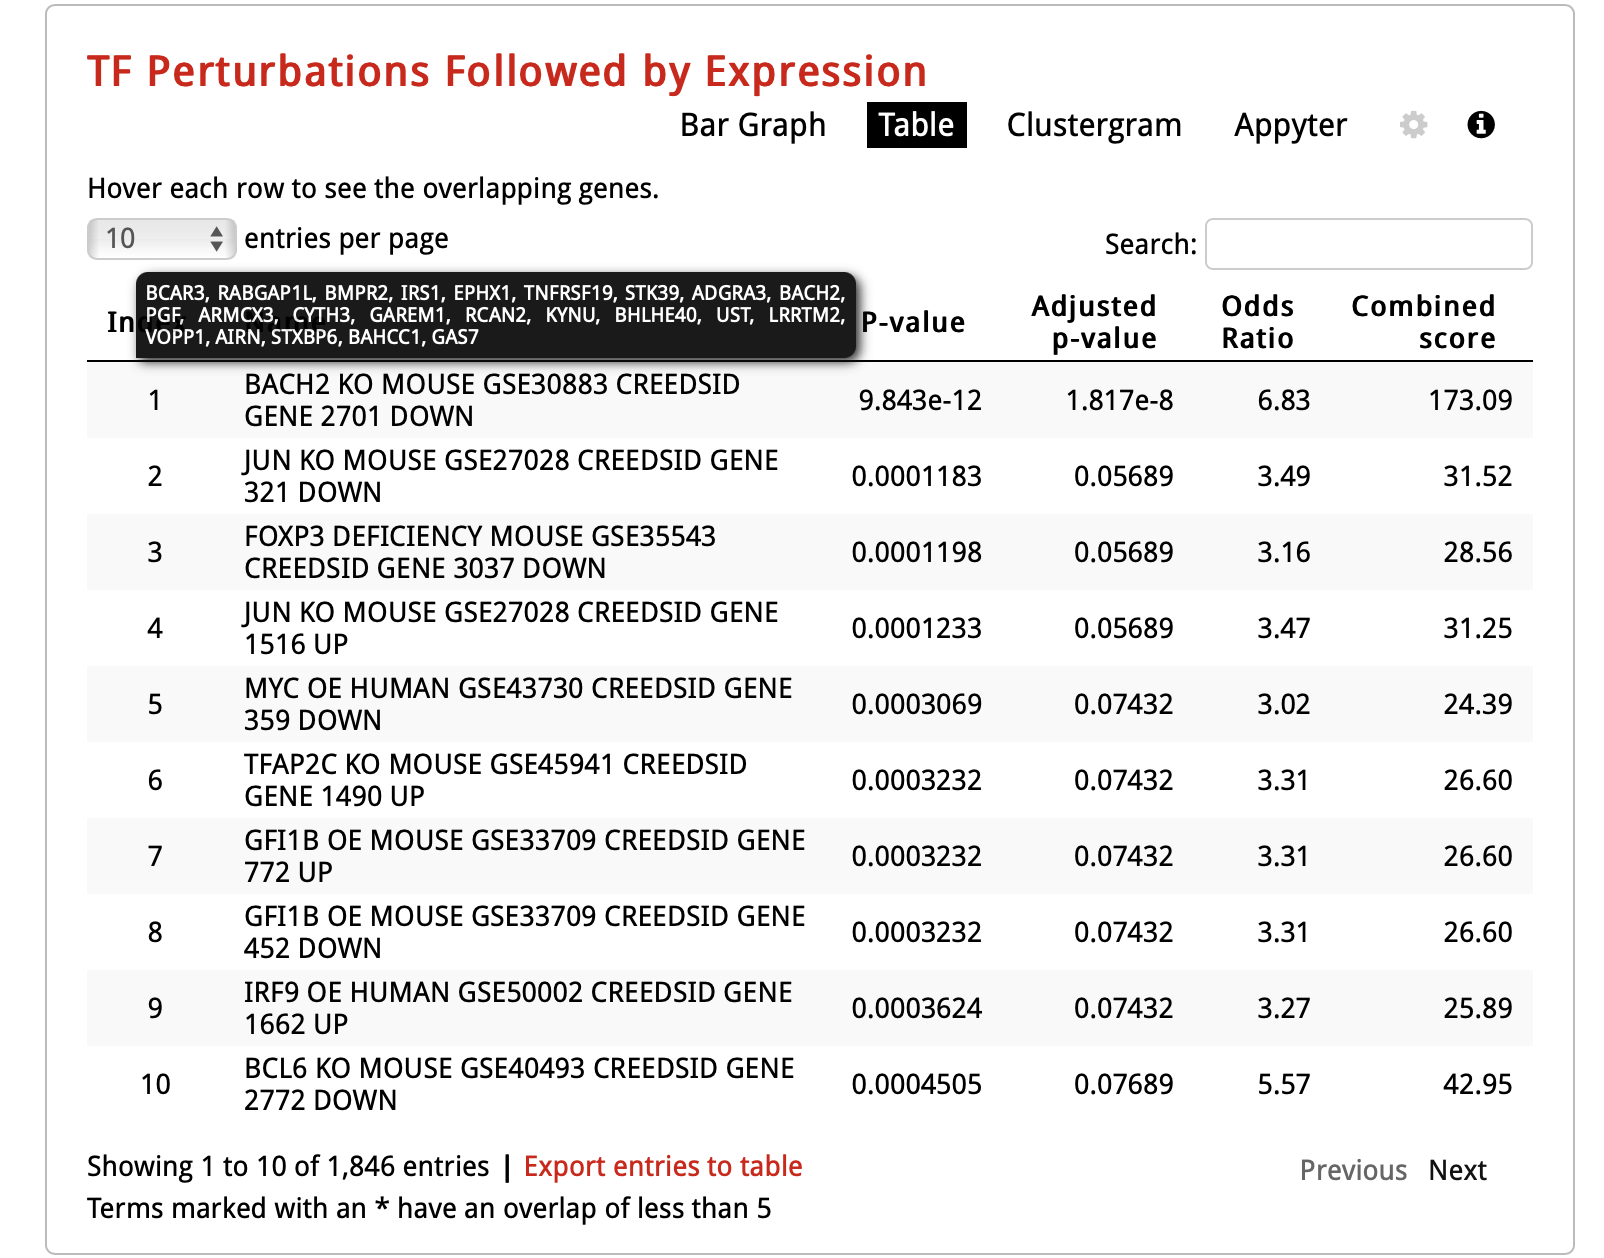

So we can see a highly significant overlap of our down-regulated genes with the ones that are also down-regulated following a murine KO for BACH transcription factor, as described in GSE30883 dataset.    
This overlap contains 23 genes (list in the black box), and we could infer that those 23 genes could be targets of BACH TF.
Other interesting potential regulators include JUN, FOXP3, MYC, TFAP2C, GF1B...

The **698 up-regulated genes** provide many interesting enrichments pertaining to immunity pathways, that could be explored at length to identify the most interesting genes:    

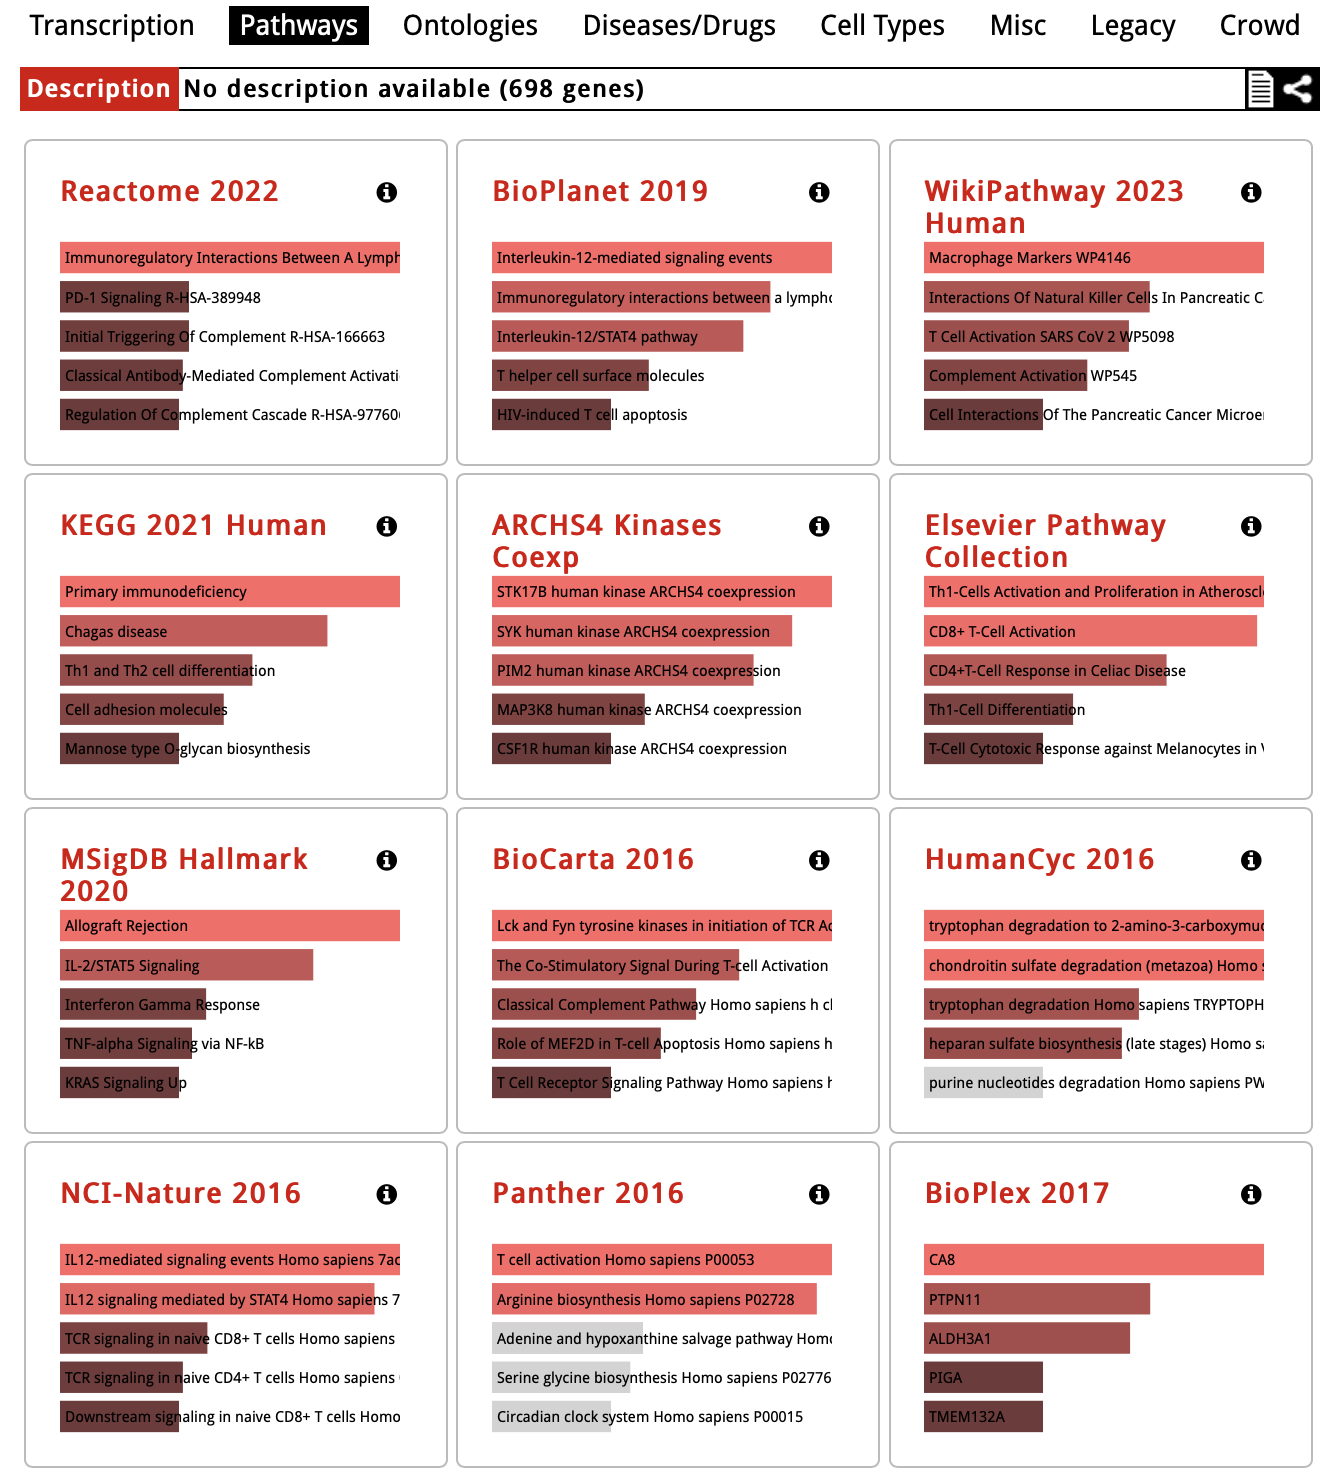


Enrichr can be implemented as a package in R, as documented here: https://rbioapi.moosa-r.com/reference/rba_enrichr.html   
Its usage appears a bit more complex than the user-friendly web-site, so it could be kept for the set-up of automatic pipelines. In most cases, the exploratory analysis of your gene lists will be efficient enough using the website.   
Furthermore, we provide below a more refined ORA procedure using clusterProfiler. 

---
---
## 3. Enrichment analysis with `clusterProfiler`
---

There are two main packages to study gene sets enrichment in R.

- [gprofiler2](https://cran.r-project.org/web/packages/gprofiler2/index.html): a CRAN packages to do similar analyses as in the web interface of [G:Profiler](https://biit.cs.ut.ee/gprofiler/gost)

- [clusterProfiler](https://bioconductor.org/packages/release/bioc/html/clusterProfiler.html) available in Bioconductor.

**clusterProfiler** is by far the most complete and flexible tool to perform ***ORAs (Over-Representation Analyses)*** that are single-gene enrichment methods, or to perform ***SAFE (Significance Analysis of Function and Expression)*** like GSEA.

Its guide is available at both these links:
- https://bioconductor.org/packages/release/bioc/vignettes/clusterProfiler/inst/doc/clusterProfiler.html
- https://yulab-smu.top/biomedical-knowledge-mining-book/index.html

---
### 3.1. ORA
---

**clusterProfiler** can be used for several ORAs on different datasets: Gene Ontology (GO), Kyoto Encyclopedia of Genes and Genomes (KEGG), Reactome, Disease Ontology (DO), Disease Gene Network (DisGeNET), wikiPathways, Molecular Signatures Database (MSigDb) and custom datasets.

We will illustrate clusterProfiler usage on GO, Reactome and KEGG.

#### **3.1-a. GO**

clusterProfiler needs **a set of unique genes**.

Let's use the top 50 DE genes.   
Of course, this is a very small list, and the enriched pathways identified below might not seem interesting in our biological context. Consider exploring gene sets of different sizes. 

In [ ]:
# Code cell 17 ##

mygenes <- unique(top50DE$gene_name) 

The function to run it for GO enrichment is `enrichGO()`. For the `ont` (Ontology) argument, we can specify either molecular function ("MF"), cellular components ("CC"), biological processes ("BP") or "ALL".

Here we use `org.Mm.eg.db` as the database collecting all genes for the mouse genome with their different identifiers. This database is available in a bioconductor package: http://bioconductor.org/packages/release/data/annotation/html/org.Mm.eg.db.html

Bioconductor has already provided OrgDb for about 20 species. If your  species of interest is not available, see [here](https://yulab-smu.top/biomedical-knowledge-mining-book/GOSemSim.html#gosemsim-supported-organisms).

<div class="alert alert-block alert-danger"><b>Caution:</b> 
When performing enrichment analyses, you should not run the analysis against all genes in the genome, but only on the subset of expressed genes in your samples. We call it the <b> <i>universe</i></b>. Here we select all unique expressed genes.
<br>
For the <code>keyType</code> in GO enrichment, we can use the genes SYMBOL rather than the ENSEMBL or ENTREZID.
    
The `minGSize` and `maxGsize` are parameters to set up the min and max of number of genes to be part of a gene set to be tested.   
Finally, we select statistical parameters: a pvalueCutoff after an adjustment for multiple testing.
</div>    

In [ ]:
# Code cell 18 #

enr_go <- enrichGO(gene = mygenes, 
             ont ="ALL", 
             OrgDb = org.Mm.eg.db,
             universe = unique(res_dHet_dHetRag_annot$gene_name),
             keyType = "SYMBOL", 
             minGSSize = 3, 
             maxGSSize = 800, 
             pvalueCutoff = 0.1, 
             pAdjustMethod = "BH")

<mark> Be patient, the above command can last a minute or so </mark>

We can visualize for example the top 10 enrichments:

In [ ]:
# Code cell 19 #

head(enr_go, 10) # but only 7 are significant!

**Several nice plots can be drawn** as described in Chapter 15 of the manual: http://yulab-smu.top/biomedical-knowledge-mining-book/enrichplot.html.

Among available plots, we can draw:

- **barplots** is the most widely used vizualization. It depict the enrichment scores (e.g. p values) and gene counts or ratios as bars whose length and color are proportional to the number of enriched genes.

In [ ]:
# Code cell n°20

options(repr.plot.width = 12, repr.plot.height = 7)
barplot(enr_go, showCategory = 7,
        label_format = function(x) stringr::str_wrap(x, width = 120)) + # to be able to see terms description in a single row : play on the number (eg. 120)
        ggtitle("barplot for ORA") ## uses ggplot2 

- **dotplots** that depict the enrichment scores (e.g. p values) and gene counts or ratio as dots whose size is proportional to the number of enriched genes. By default they are sorted by increasing p adjust pvalue.

*A warning could be displayed, it is not present when using up-to-date packages.*

In [ ]:
# Code cell n°21

options(repr.plot.width = 12, repr.plot.height = 7)
dotplot(enr_go,
        showCategory = 9)
        label_format = function(x) stringr::str_wrap(x, width=120) +
        ggtitle("dotplot for ORA")

- **emapplots (enrichment map plots)**: Enrichment map organizes enriched terms into a network with edges connecting overlapping gene sets. In this way, mutually overlapping gene sets tend to cluster together, making it easy to identify functional modules.

In [ ]:
# Code cell n°22

options(repr.plot.width = 30, repr.plot.height= 10)
enr_go <- enrichplot::pairwise_termsim(enr_go, method = "JC", semData = "org.Mm.eg.db")
emapplot(enr_go, showCategory = 20)

<mark> Do not hesitate to rerun the above command if the figure displayed is not readable. The layout changes every time it is run.</mark>

- **treeplots**: displays a hierarchical clustering of enriched terms (after pairwise step in previous cell)

In the clusterProfiler version installed at the IFB, the `treeplot()` function is not yet present ine the package. If you are working with a more recent version, the command would be the following:

and the output is like this:
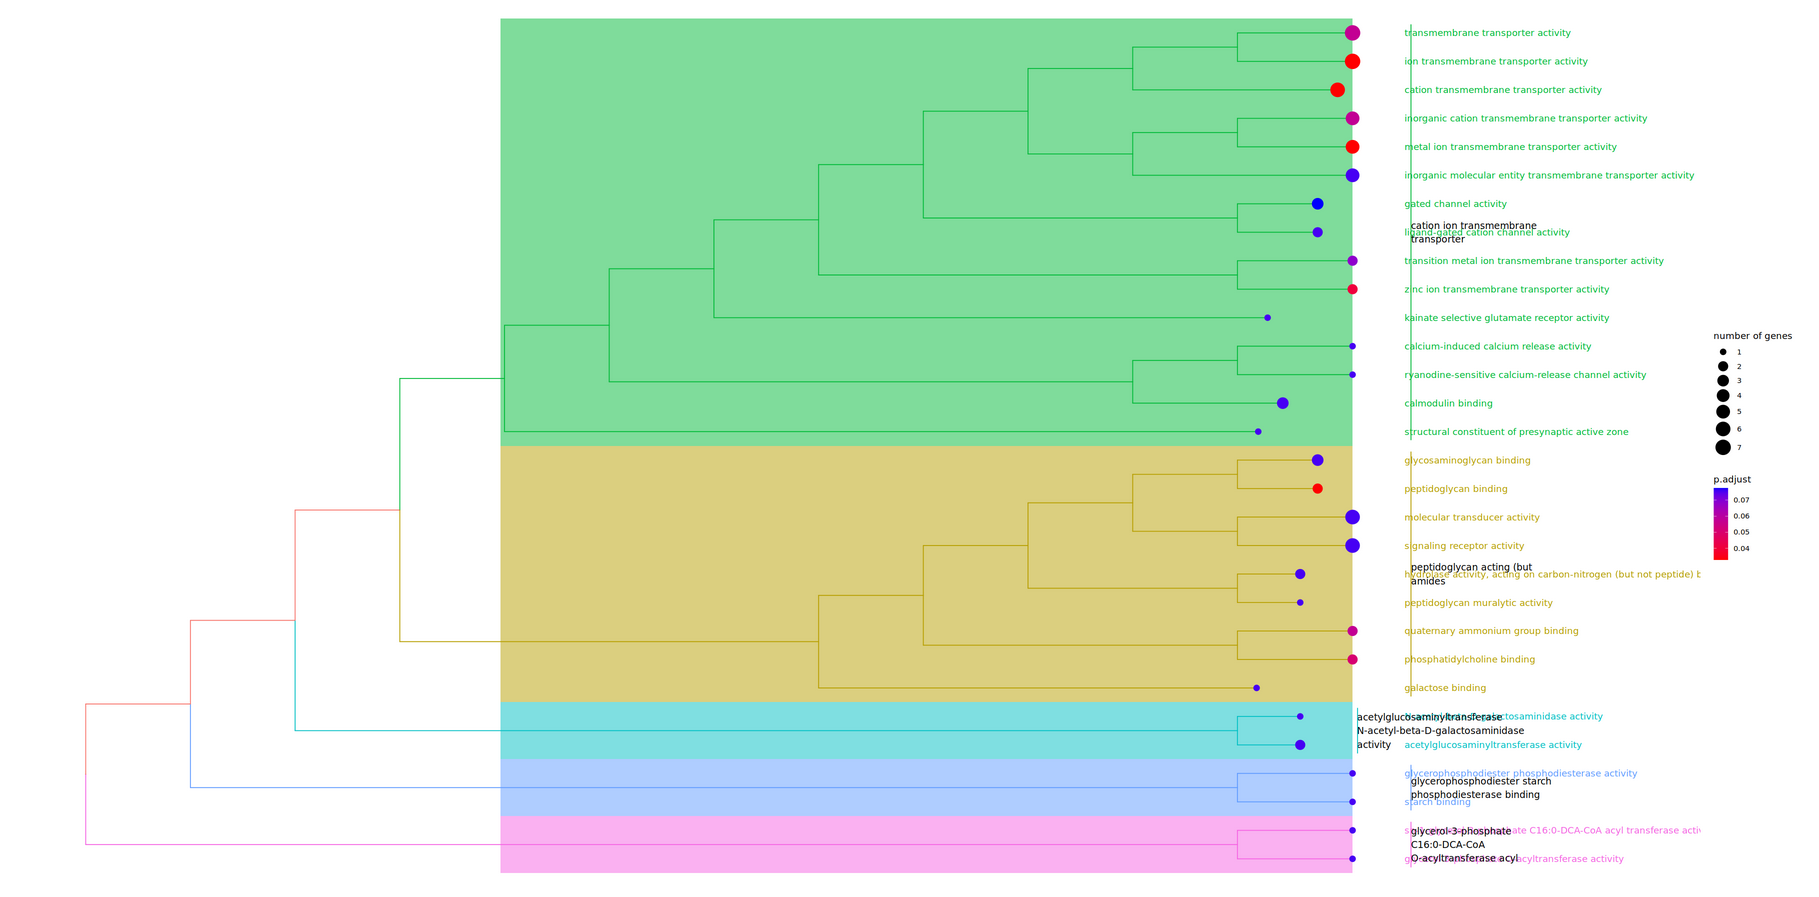 

- **upsetplots**: displays the association between genes and gene sets. It emphasizes the gene overlapping among different gene sets.

In [ ]:
# Code cell n°23

options(repr.plot.width = 15, repr.plot.height = 10)

upsetplot(enr_go)

- **cnet plots**: depict the linkages of genes and biological concepts (e.g. GO terms or KEGG pathways) as a network.

One plot often generated like the upsetplot is the cnetplot that depicts the linkages of genes and biological concepts (e.g. GO terms or KEGG pathways) as a network.

In [ ]:
# Code cell n°24

cnetplot(enr_go, categorySize ="pvalue", showCategory = 5)

There are many more plots available. The package clusterProfiler is in constant development with new plots. 

#### **3.1-b. Reactome**

Similarly, we can run the ORA on Reactome pathways. It uses the gene Entrez IDs rather than the gene symbols. So we have to get them.
The function `bitr()` generates the correspondance when available.

In [ ]:
# Code cell n°25

mygenes_entrezid <- clusterProfiler::bitr(mygenes,
                                          fromType = 'SYMBOL',
                                          toType = 'ENTREZID',
                                          OrgDb = 'org.Mm.eg.db')
mygenes_entrezid

With a 10% FDR, we retrieve no pathway here. So to show you the command, we increase the threshold at 20%.

In [ ]:
# Code cell n°26

enr_react <- enrichPathway(gene = mygenes_entrezid$ENTREZID,
                           organism = "mouse",
                           pvalueCutoff = 0.20,
                           readable = TRUE)
head(enr_react)


You can draw any figures as above.

In [ ]:
# Code cell n°27

options(repr.plot.width = 12, repr.plot.height = 7)
dotplot(enr_react,
        showCategory = 5)+
        ggtitle("dotplot for ORA")

#### **3.1-c. KEGG**

Similarly, we can run the ORA on KEGG pathways. The trick here is not to use gene name symbols, nor Gene IDs but their matching Uniprot IDs. The function `bitr()` generates the correspondance when available.


In [ ]:
# Code cell n°28

mygenes_uniprot <- clusterProfiler::bitr(mygenes,
                                         fromType = 'SYMBOL',
                                         toType = 'UNIPROT',
                                         OrgDb = 'org.Mm.eg.db')
mygenes_uniprot

As you can see, several UniprotIDs may exist for a given gene.

In [ ]:
# Code cell n°29

table(mygenes_uniprot$SYMBOL)

Thus, duplicated IDs must be removed if any UNIPROT IDs taken.

In [ ]:
# Code cell n°30

mygenes_uniprot <- mygenes_uniprot[!duplicated(mygenes_uniprot$SYMBOL), ]
mygenes_uniprot


You do the same gene SYMBOL to UNIPROT conversion for the universe:

In [ ]:
# Code cell n°31

prot_universe <- unique(res_dHet_dHetRag_annot$gene_name)
prot_universe <- clusterProfiler::bitr(prot_universe,
                                       fromType = 'SYMBOL',
                                       toType = 'UNIPROT',
                                       OrgDb = 'org.Mm.eg.db')
prot_universe <- prot_universe[!duplicated(prot_universe$SYMBOL), ]
head(prot_universe)

You are now ready for the enrichment analysis on KEGG.

In [ ]:
# Code cell 32

enr_kegg <- enrichKEGG(gene = mygenes_uniprot$UNIPROT,
             keyType = "uniprot",
             minGSSize = 3,
             maxGSSize = 800,
             pvalueCutoff = 1,
             universe = prot_universe$UNIPROT,
             organism = "mmu",
             pAdjustMethod = "none")

Since your teachers managed to run the above cell on in another computer with the updated versions, they saved the object "enr_kegg" and put it in `/shared/project/2312_rnaseq_cea/allData/Data/ORA_GSEA`. We can just load it and keep going. 

In [ ]:
# Code cell n°33

dotplot(enr_kegg)

In [ ]:
#Code cell n°34

options(repr.plot.width = 20, repr.plot.height = 15)
enr_kegg <- pairwise_termsim(enr_kegg, method = "JC", semData = "org.Mm.eg.db")
emapplot(enr_kegg, max.overlaps = 70, cex.params = list(category_label = 0.9))


In [ ]:
# Code cell n°35

enr_kegg2 <- setReadable(enr_kegg, OrgDb = "org.Mm.eg.db", "UNIPROT")
cnetplot(enr_kegg2, categorySize="pvalue", showCategory = 5, cex.params = list(category_label = 1.1))


---
### 3.2. GSEA
---

GSEA, standing for Gene Set Enrichment Analysis, is a Significance Analysis of Function and Expression (SAFE) method. While ORAs (over-representation methods) are single-gene approaches, **GSEA uses all genes in the dataset** and their potential correlation. This method determines whether a pre-defined set of genes (ex: genes belonging to a specific GO term or KEGG pathway) shows statistically significant, concordant differences between two biological states. In addition, **it uses quantitative metrics** like gene expression or statistics results from a DGE analysis. This later is the most recommended approach to follow, and is known as “pre-ranked GSEA” which takes as input a gene list sorted by a metric of differential expression, commonly either the log2 fold-change or ranked test-statistic (minus value if underexpressed).

One benefit of GSEA over GO over-representation analysis (i.e hard-filtered DE genes, venn diagrams and hypergeometric tests) is that GSEA does not use arbitrary cutoffs for differential expression significance. GSEA input gene lists do not need to be filtered because genes near the center of the list, meaning a fold-change near 0, are effectively down-weighted to insignificance. 


[GSEA](https://www.gsea-msigdb.org/gsea/index.jsp) was developped at the Broad Institue. The documentation is available [here](https://www.gsea-msigdb.org/gsea/doc/GSEAUserGuideFrame.html). It was described in [Subramanian et al. 2005](https://doi.org/10.1073/pnas.0506580102)

We can run a Gene Set Enrichment Aanalysis (GSEA) with the Broad tool or directly with clusterProfiler. We need first to sort genes by a quantitative metrics, here the log2 Fold-Change.


Here we start with the gsea tool integrated in clusterProfiler.
We used it here with the DGE results of the dHetRag samples versus dHet samples, on GO terms.
First, we sort the genes by the log2 Fold-Change and we remove the duplicated ones.

In [ ]:
# Code cell n°36

sorted_genes <- res_dHet_dHetRag_annot[order(res_dHet_dHetRag_annot$log2FoldChange, decreasing = T),]

# To verify that the genes were sorted by decreasing Fold-change
head(sorted_genes)
tail(sorted_genes)

# We also remove duplicated genes 
sorted_genes <- sorted_genes[!duplicated(sorted_genes$gene_name), ]

# and we just save a vector of the orderedlog2FC with the gene_name as an attribute to the vector
sorted_genes_log2FC <- sorted_genes$log2FoldChange
names(sorted_genes_log2FC) <- sorted_genes$gene_name
str(sorted_genes_log2FC)
head(sorted_genes_log2FC)


Now we can run the gsea analysis:

In [ ]:
# Code cell n°37

gsea_go <- gseGO(geneList = sorted_genes_log2FC, 
             ont ="ALL", 
             keyType = "SYMBOL",
             minGSSize = 3, 
             maxGSSize = 800, 
             pvalueCutoff = 0.25, 
             verbose = TRUE, 
             OrgDb = org.Mm.eg.db, 
             pAdjustMethod = "none",
                 nPerm = 7500)    # by default there are 1000 permutations

<mark> It may take a long time and use a lot of memory due to permutations.</mark>

Let's see the result of the 2 top enriched pathways.

In [ ]:
# Code cell n°38

options(repr.plot.width = 15, repr.plot.height = 10) 
gseaplot2(gsea_go, geneSetID = 1, title = gsea_go$Description[1])

In [ ]:
# Code cell n°39

# this time we add the p-value for the enrichment of the pathway
gseaplot2(gsea_go, geneSetID = 2, title = gsea_go$Description[2], pvalue_table = TRUE)

We can also display several patways on the same plot.

In [ ]:
# Code cell n°40

gseaplot2(gsea_go, geneSetID = 1:3, title = "top 3 gene sets", pvalue_table = TRUE,
          color = c("#E495A5", "#86B875", "#7DB0DD"), ES_geom = "dot")

We can also look at the usual figures implemented in clusterProfiler, such as dotplots :

In [ ]:
# Code cell n°41

options(repr.plot.width = 17, repr.plot.height = 10)
dotplot(gsea_go, showCategory=20)+
        #label_format = function(x) stringr::str_wrap(x, width=  120))+
        ggtitle("dotplot for GSEA")

or emapplots:

In [ ]:
# Code cell n°42

options(repr.plot.width = 15, repr.plot.height = 10)

gsea_go <- enrichplot::pairwise_termsim(gsea_go, method = "JC", semData = "org.Mm.eg.db")
emapplot(gsea_go, showCategory = 20)

or the cnetplots :


In [ ]:
# Code cell n°43

options(repr.plot.width=10, repr.plot.height= 8)
    cnetplot(gsea_go, categorySize="pvalue", showCategory = 5)

The size of the plot can impact the figure: see the same figure with higher height!

In [ ]:
# Code cell n°44

options(repr.plot.width = 18, repr.plot.height = 18)
cnetplot(gsea_go, categorySize="pvalue", showCategory = 5, max.overlaps = 100)

We can also use the **ridgeplot** format which visualizes expression distributions of core enriched genes for GSEA enriched categories. It helps users to interpret up/down-regulated pathways.

In [ ]:
# Code cell n°45

options(repr.plot.width = 30, repr.plot.height = 10)
ridgeplot(gsea_go, label_format = function(x) stringr::str_wrap(x, width=  120))

The x axis is the log2(FC) distribution of genes in pathways. Here all enriched pathways are upregulated!

As you can see in the warning above, some P-values were likely overestimated, and the plots show indeed that the minimal p-values are 1e-10. Setting the epsilon argument to 0 will increase the accuracy of the p-value calculations of the enriched gene sets.

In [ ]:
# Code cell n°46

gsea_go2 <- gseGO(geneList = sorted_genes_log2FC, 
             ont ="ALL", 
             keyType = "SYMBOL",
             minGSSize = 3, 
             maxGSSize = 800, 
             pvalueCutoff = 0.25, 
             verbose = TRUE, 
             OrgDb = org.Mm.eg.db, 
             pAdjustMethod = "none",
             nPermSimple = 7500, # by default there are 1000 permutations
             eps = 0)

Let's see how this new computation changes the results:

In [ ]:
# Code cell n°47

options(repr.plot.width = 15, repr.plot.height = 10) 
gseaplot2(gsea_go2, geneSetID = 1:3, title = "top 3 gene sets", pvalue_table = TRUE,
          color = c("#E495A5", "#86B875", "#7DB0DD"), ES_geom = "dot")

and the updated dotplot:

In [ ]:
# Code cell n°48

options(repr.plot.width = 17, repr.plot.height = 15)
dotplot(gsea_go2, showCategory=20)+
        #label_format = function(x) stringr::str_wrap(x, width=  120))+
        ggtitle("dotplot for GSEA")

or emapplot:

In [ ]:
# Code cell n°49

options(repr.plot.width = 15, repr.plot.height = 10)

gsea_go2 <- enrichplot::pairwise_termsim(gsea_go2, method = "JC", semData = "org.Mm.eg.db")
emapplot(gsea_go2, showCategory = 20)

or the cnetplot:

In [ ]:
# Code cell n°50

options(repr.plot.width = 18, repr.plot.height = 18)
cnetplot(gsea_go2, categorySize="pvalue", showCategory = 5, max.overlaps = 100)

or the ridgeplot:

In [ ]:
# Code cell n°51

options(repr.plot.width = 30, repr.plot.height = 15)
ridgeplot(gsea_go2, label_format = function(x) stringr::str_wrap(x, width=  120))

---
---
## 4. GSEA with the Java application:
---

### 4.1. Preparing input files
---

The GSEA Java application is a stand-alone software to run GSEA on your own computer. 

**Two GSEA methods** are implemented in the Java application:
1. with unranked expression data: GSEA will cluster genes by similarity (different metrics/methods can be used).
2. with pre-ranked expression data: this method is the recommended one. After DGE analysis, we usually upload the data ranked by the statistics, or (and this is equivalent) ranked by the signed pvalue (meaning a positive pvalue when the fold change is positive, a negative pvalue when the fold change is negative).

Whatever the method used, GSEA can only compare two conditions.

GSEA requires **two input files:**
- an expression file
- a phenotype file

***The format for the different inputs is described [here](https://software.broadinstitute.org/cancer/software/gsea/wiki/index.php/Data_formats)***

#### **4.1-a. Expression files**

There are 4 acceptable formats for expression input files: .gct, .res, .pcl and .txt. Here we will prepare files in .txt format with R. It requires to fill a first column NAMES with the names of the genes/probes, followed by a column DESCRIPTION that is mandatory (with proper gene description, or NA values; a bug in GSEA requires this column although it is not informative; they will try to fix this issue in a future release), then a column for each sample.

if we start from normalised unranked values:
We use the norm_counts object with the following structure:

In [ ]:
# Code cell n°52

str(norm_counts)

We keep the variable gene_name and the normalized count data + we create the extra column`Description`.

In [ ]:
# Code cell n°53

gsea_norm_counts <- data.frame("NAMES" = norm_counts$gene_name, "DESCRIPTION" = NA, norm_counts[3:13])
head(gsea_norm_counts, n = 5)

dim(gsea_norm_counts)

str(gsea_norm_counts)
write.table(gsea_norm_counts, file=paste0(gseafolder, "gsea_norm_counts.txt"), sep="\t", col.names = TRUE, quote = FALSE, row.names = FALSE)

- if we start from ***preranked values***: using the signed pvalues

The format is RNK: Ranked list file format (`*.rnk`) 
We will use the object `sorted_genes` we generated in cell 36 of this notebook. Let's have a look again at its structure, first and last rows:

In [ ]:
# Code cell n°54

str(sorted_genes)
head(sorted_genes, n = 4)
tail(sorted_genes, n = 4)

We now generate the file with the GSEA format and save it on the computer:

In [ ]:
# Code cell n°55

gsea_dHet_dHetRag <- data.frame(sorted_genes$gene_name, sorted_genes$log2FoldChange)
write.table(gsea_dHet_dHetRag, file=paste0(gseafolder, "gsea_dHet_dHetRag.rnk"), sep="\t", col.names = FALSE, quote = FALSE, row.names = FALSE)

#### **4.1-b. Phenotype files**

The format `.cls` format is the one for phenotypes.

**1.** On the first line, you specify 3 values separated by spaces:
- the number of samples
- the number of classes (or levels of your factor of interest)
- 1: always, don't change it

**2.** On the second line, you put names for each class as they will appear in analysis report. The line should begin with a hashtag sign (#) followed by a space.

**3.** The third line contains a class label for each sample. The class label can be the class name, a number, or a text string. The first label used is assigned to the first class named on the second line; the second unique label is assigned to the second class named; and so on. The number of class labels specified on this line should be the same as the number of samples specified in the first line. The number of unique class labels specified on this line should be the same as the number of classes specified in the first line.


You can prepare one phenotype file per contrast of interest, as for example between dHetRag and dHet samples, or more directly a unique file with all conditions that will allow later in GSEA to choose your contrast of interest.

Here, we will build this `.cls` file with the `samples` object we loaded in our session. Let's check how it looks like first:

In [ ]:
# Code cell n°56

str(samples)
samples

We now write the file in our computer with the requested format:

In [ ]:
# Code cell n°57

gsea_pheno <- file(paste0(gseafolder, "gsea_pheno.cls"))
my_text <- paste0("11 3 1\n#dHet dHetRag WT\n", paste(samples$Condition, collapse=" "))
writeLines(my_text, gsea_pheno)
close(gsea_pheno)

You should see the gsea_pheno.cls file in the left column (in the Results/gseafolder). Open it to check its content.

<div class="alert alert-block alert-success"><b>Well done:</b>
You now have all the files correctly formatted to run GSEA with its Java stand alone application. <br>
    Dowload the 3 files on your computer.
</div>

---
### 4.2. Running GSEA (Java Stand-Alone Application)
---

You are ready to run your first GSEA analyses!

Download the Java application from [here](http://www.gsea-msigdb.org/gsea/downloads.jsp) with the appropriate version for your OS and execute the installer. If you chose the source file, unzip the downloaded file and launch GSEA by double-clicking on `gsea.bat` if you are on Windows, by double-clicking on the App or on the `gsea.command` if you are on macOS, or by typing the command `./gsea.sh` if you are on Linux or on macOS.

In File>Preferences, specify the directory where you want the GSEA results to be saved. By default it is in your home repository `/gsea_home/output`.

Click on `Load Data` and upload the different input files. No error must be reported if your files are correctly formatted.

#### <u>**4.2-a.** If you are using the **method with unranked values:**</u>

- Click on **Run GSEA**

- In **Required fields**, select the correct filed and parameters:
    - `gsea_norm_counts.txt` for the expression dataset
    - choose the gene set database of interest with the correct species
    - start with keeping 1000 permutations: if you have pvalues displayed at 0, then rerun the analysis increasing the number of permutations
    - for phenotype labels, select one of the `.cls` file and the contrast of interest
    - keep the option `collapse` to deal with IDs for the same gene
    - choose `phenotype` for permutation if you have several samples per category (7 are recommanded), otherwise select `gene_set` but the statistical test will not be able to account for putative correlations between genes.
    - select <mark> here  `Mouse_Gene_Symbol_Remapping_MSigDB.v2023.1.Mm.chip` since we are working with gene symbols and we need their correspondance in MSigDB </mark>.<br>
<br>
- In **Basic fields** enter a useful name for your analysis and select a method to rank genes. You can also specify the output folder name.

- Click on **Run** at the bottom.

- You can then run a **Leading edge** analysis and vizualize enrichment map. The enrichment outputs can also be imported to `Cytoscape` using the Cytoscape app `EnrichmentMap`.
    
#### <u>**4.2-b.** If you are using the **method with pre-ranked values**:</u>

- Click on **Run GSEAPreranked**

- Select in **Required fileds** the correct files and parameters:<br>
    - choose the gene set database of interest (eg `mh.all.v2023.1.Mm.symbols.gmt`)
    - start with keeping 1000 permutations: if you have pvalues displayed at 0, then rerun the analysis by increasing the number of permutations
    - for the ranked list, select for example `gsea_dHet_dHetRag.rbk`
    - keep the option `collapse` to deal with several probes for the same gene
    - select <mark> here `Mouse_Gene_Symbol_Remapping_MSigDB.v2023.1.Mm.chip` since we are working with gene symbols and we need their correspondance in MSigDB</mark>.<br>
<br>
- In **Basic fields** enter a useful name for your analysis and select a method to rank genes. You can also specify the output folder name.

- Click on **Run** at the bottom.

- You can then run a **Leading edge** analysis and vizualize enrichment map. The enrichment outputs can also be imported to `Cytoscape` using the Cytoscape app `EnrichmentMap`.


<div class="alert alert-block alert-success"><b>Well done:</b>
If your analysis was succesfull, you see <code>Success</code> in green in the "GSEA Reports" frame on the left panel.  Just click on <code>Success</code> to look at the results. Follow the <a href=https://www.gsea-msigdb.org/gsea/doc/GSEAUserGuideFrame.html>guide</a> to understand the outputs. A FDR of 25% is the minimum required to consider a significant enrichment.

</div>

>***Note: GSEA in R:***
>- an R package exists to run GSEA: [GSEABase](https://bioconductor.org/packages/release/bioc/html/GSEABase.html)
>- the package clusterProfiler also implements GSEA (see part 3.2 of this tutorial) and even a fastest approach (fgsea).

---
---

---
## 5. WGCNA 
---

The WGCNA method builds “weighted gene correlation networks for analysis” from expression data. 
It was originally published in 2008 and cited as the following:

    Langfelder, P. and Horvath, S., 2008. WGCNA: an R package for weighted correlation network analysis. BMC bioinformatics, 9(1), p.559.
    Zhang, B. and Horvath, S., 2005. A general framework for weighted gene co-expression network analysis. Statistical applications in genetics and molecular biology, 4(1).



WGCNA begins with the understanding that the information captured by expression experiments is far richer than a list of differentially expressed genes.    
Rather, expression data are more completely represented by considering the relationships between measured transcripts, which can be assessed by pair-wise correlations between gene expression profiles. In most transcriptomic data analyses, however, these relationships go essentially unexplored. WGCNA starts from the level of thousands of genes, identifies clinically interesting gene modules, and finally uses intramodular connectivity, gene significance (e.g. based on the correlation of a gene expression profile with a sample trait) to identify key genes in the disease pathways for further validation.   

This is an unbiased approach that: 
 - construct a co-expression network from the complete expression dataset
 - clusters similarly expressed genes into groups (termed 'modules') using hierarchical clustering
 - relate these modules to external information, by calculating their correlation with quantitative or categorical traits measured in the experiment, or to gene information such as GO or KEGG 
 - study relationships between modules to reduce dimensionality
 - provide information about potential key driver genes (hub genes) in interesting modules for further validation

WGCNA alleviates the multiple testing problem inherent in microarray or RNAseq data analysis. Instead of relating thousands of genes to a sample trait, it focuses on the relationship between a few (typically less than 10) modules and sample traits. Toward this end, it calculates the eigengene significance (correlation between sample trait and eigengene) and the corresponding p-value for each module. The module definition does not make use of a priori defined gene sets (that last point is a very important difference with the GSEA method seen above). Instead, modules are constructed from the expression data by using hierarchical clustering. Although it is advisable to relate the resulting modules to gene ontology information to assess their biological plausibility, it is not required.    

Because the modules may correspond to biological pathways, focusing the analysis on intramodular hub genes (or the module eigengenes) amounts to a biologically motivated data reduction scheme. Because the expression profiles of intramodular hub genes are highly correlated, typically dozens of candidate biomarkers result. Although these candidates are statistically equivalent, they may differ in terms of biological plausibility or clinical utility. Gene ontology information can be useful for further prioritizing intramodular hub genes.   

The following section is adapted from the original tutorial there: https://horvath.genetics.ucla.edu/html/CoexpressionNetwork/Rpackages/WGCNA/Tutorials/
with the help of adaptations for RNAseq foud here: https://wikis.utexas.edu/display/bioiteam/Clustering+using+WGCNA


### 5.0. Installing package and adjusting functions

In [ ]:
# Code cell n°58

install.packages("flashClust")
install.packages("WGCNA")

library(flashClust)
library(WGCNA)

sessionInfo()

Allow multi-threading within WGCNA. This helps speed up certain calculations.

In [ ]:
# Code cell n°59

enableWGCNAThreads(nThreads = 6) # to be adjusted to the exact size of your session

As we can see above when loading the library, one of the function included in the `flashClust` library is masked by the same function from the package `stat`.   
In order to avoir potential conflict, we temporarily reassign this function to the one present in the `flashClust` library (i.e we force R to use this specific command when we run `hclust`).

In [ ]:
# Code cell n°60

hclust <- flashClust::hclust

We do the same for the correlation function, in order to be sure to use the proper one in this section. 

In [ ]:
# Code cell n°61

# This step is necessary to avoid an error arising from the use of different cor() functions.
# Fix found thanks to a japanese post :-) https://qiita.com/Razumall/items/8aa6417f78c4857b3670 
# More info there: https://programmersought.com/article/90752004413/

cor <- WGCNA::cor

### 5.1. Input Data 

Uploading data into R and formatting it for WGCNA. 

#### * Expression data

This creates an object called "datExpr" that contains the normalized counts file output from DESeq2.

In [ ]:
# Code cell n°62
 
data <- norm_counts[1:13]

# You see that genes are listed in a column named "ensemblID" and samples are in columns
head(data) 

dim(data)

Manipulate file so it matches the format WGCNA needs:   
- samples in rows   
- genes in columns


In [ ]:
# Code cell n°63

datExpr = as.data.frame(t(data[, -c(1:2)]));
names(datExpr) = data$ensemblID;
rownames(datExpr) = names(data)[-c(1:2)];

# now samples are rows and genes are columns
head(datExpr, 13)

The following commands check if there are gene outliers

In [ ]:
# Code cell n°64

gsg = goodSamplesGenes(datExpr, verbose = 3)
gsg$allOK
 
 

If the last statement returns TRUE, all genes have passed the cuts.   
If not, we remove the offending genes and samples from the data with the following command (uncomment the command lines)

In [ ]:
# Code cell n°64b (optional)

#if (!gsg$allOK)
#   {if (sum(!gsg$goodGenes)>0)
#       printFlush(paste("Removing genes:", paste(names(datExpr)[!gsg$goodGenes], collapse= ", ")));
#       if (sum(!gsg$goodSamples)>0)
#           printFlush(paste("Removing samples:", paste(rownames(datExpr)[!gsg$goodSamples], collapse=", ")))
#       datExpr= datExpr[gsg$goodSamples, gsg$goodGenes]
#       }
 

We plot the corresponding tree:

In [ ]:
# Code cell n°65

sampleTree = hclust(dist(datExpr), method = "average");

options(repr.plot.width = 14, repr.plot.height = 7) 
par(cex = 0.6);
par(mar = c(0,4,2,0))
plot <- plot(sampleTree, main = "Sample clustering to detect outliers", sub="", xlab="", 
             cex = 1.5,
             cex.lab = 1.5, 
             cex.axis = 1.5, 
             cex.main = 2)

# Plot a line to show the cut: useless here as no outliers are present in our samples
abline(h = 160, col = "red")

In the case you have outlier(s), the commands below will remove them and recalculate the clustering: 

In [ ]:
# Code cell n°65b (optional)

# Determine cluster under the line
#clust = cutreeStatic(sampleTree, cutHeight = 15, minSize = 10)
#table(clust)
# clust 1 contains the samples we want to keep.
#keepSamples = (clust==1)
#datExpr = datExpr0[keepSamples, ]
#nGenes = ncol(datExpr)
#nSamples = nrow(datExpr)

#### * Quantitative Traits   
We load the quantitative information that will be used to give meaning to the genes groups.   
Most of the times, this will be clinical traits or measurements pertaining to your biological question.   

Here, we did not retrieve clinical observations with the dataset, so we arbitrarly joined two values to the sample data:   
- a survival values in days 
- a weight at death, in g

The values were chosen out of the blue but respecting the groups of mice (replicates for the same mouse have the same values, and mice within a condition have been attributed coherent values).

In [ ]:
# Code cell n°66

#Create an object called "datTraits" that contains your trait data

datTraits0 <- read.table(paste0(gohome,"alldata/Data/sampleData-GSE158661-traits.tsv"),
                      sep = "\t",
                      header = TRUE,
                      stringsAsFactors = FALSE)

head(datTraits0, 12)

In [ ]:
# Code cell n°67

#form a data frame analogous to expression data that will hold the clinical traits.
rownames(datTraits0) <- datTraits0$SampleName
head(datTraits0, 12)

The following command check that the two datasets align correctly.   
If it does not return `TRUE`, your names are out of order.

In [ ]:
# Code cell n°68

datTraits0$SampleName = NULL
table(rownames(datTraits0)==rownames(datExpr))
head(datTraits0, 12)
 

We remove columns that hold information we do not need.

In [ ]:
# Code cell n°69

datTraits <- datTraits0[, -c(1:9)]
head(datTraits, 12)
dim(datTraits)

You have finished uploading and formatting expression and trait data.    
Expression data is in `datExpr`, corresponding traits are in `datTraits`.  
We save these in a R object in the wgcnafolder directory that was created at the beginning of the notebook.

In [ ]:
# Code cell n°70

save(datExpr, datTraits, file=paste0(wgcnafolder,"SamplesAndTraits.RData"))


We re-cluster samples, to display the clustering together with quantitative traits:

In [ ]:
# Code cell n°71

options(repr.plot.width = 14, repr.plot.height = 8) 
sampleTree2 = hclust(dist(datExpr), method = "average")
# Convert traits to a color representation: white means low, red means high, grey means missing entry
traitColors = numbers2colors(datTraits, signed = FALSE);
# Plot the sample dendrogram and the colors underneath.
plotDendroAndColors(sampleTree2, traitColors,
                    groupLabels = names(datTraits), 
                    main = "Sample dendrogram and trait heatmap")

The author of WGCNA implemented a function to free memory usage along the analysis.   
Therefore, after each memory-intensive step, we can run this command to get ready for the next step.

In [ ]:
# Code cell n°72

collectGarbage()

### 5.2. Network Construction

#### Step 1: Choosing the correct power parameter

In this step, we are going to analyse the expression data to infer `power`, a parameter used to build the network.   
So we first calculate a scale free topology index for a range a power values, and we plot the resulting network analysis to choose the proper value.

In [ ]:
# Code cell n°73 (optional)

# Load the expression and trait data saved in the first part
stdata <- paste0(wgcnafolder, "SamplesAndTraits.RData")
stdata
load(stdata, verbose = TRUE)

We choose a set of soft-thresholding powers to test on our data:

In [ ]:
# Code cell n°74
 
# Choose a set of soft powers
powers = c(c(1:10), seq(from =10, to=37, by=1)) #choosing a set of soft-thresholding powers

# Call the network topology analysis function
sft = pickSoftThreshold(datExpr, powerVector=powers, verbose =5) #call network topology analysis function

# For information, we could perform an analysis considering the network as "signed", but as we have few samples, the SFT index is reduced. 
# We would end with a higher value for the chosen power (36 instead of 33)
#sft = pickSoftThreshold(datExpr, powerVector=powers, verbose =5, networkType="signed") #call network topology analysis function

Plot the results:

In [ ]:
# Code cell n°75

options(repr.plot.width = 25, repr.plot.height = 10) 
par(mfrow = c(1,2));
cex1 = 0.9;
# Scale-free topology fit index as a function of the soft-thresholding power
plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     xlab="Soft Threshold (power)",ylab="Scale Free Topology Model Fit, R^2",type="n",
     main = paste("Scale independence"));
text(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     labels=powers,cex=cex1,col="red");
# this line corresponds to using an R^2 cut-off of h
abline(h=0.90,col="red")

# Mean connectivity as a function of the soft-thresholding power
plot(sft$fitIndices[,1], sft$fitIndices[,5],
     xlab="Soft Threshold (power)",ylab="Mean Connectivity", type="n",
     main = paste("Mean connectivity"))
text(sft$fitIndices[,1], sft$fitIndices[,5], labels=powers, cex=cex1,col="blue")

collectGarbage()

The red line is the threshold the scale free topology index has to reach: 0.90.   
From this plot, we see that we can choose a power of 33, since it's the lowest value for which the scale free topology index reaches 0.90. 

#### **Step 2: Construct a gene co-expression network and identify modules**  
Using this value, we now build the network by calculating correlations between genes, and generate **modules**, i.e. groups of correlated genes.

The following cells build the network in a step-wise manner. 

<mark> Each step may take a long time and use a lot of memory, depending on the chosen power value and the number of genes.</mark>

- Build an adjacency "correlation" matrix

In [ ]:
# Code cell n°76

enableWGCNAThreads(nThreads = 6)
softPower <- 33
adjacency <- adjacency(datExpr, power = softPower, type = "unsigned") # specify network type
head(adjacency)
 
collectGarbage()

- Construct Network

In [ ]:
# Code cell n°77

#translate the adjacency into topological overlap matrix (TOM) and calculate the corresponding dissimilarity:
TOM = TOMsimilarity(adjacency, TOMType="unsigned") # specify network type
dissTOM = 1-TOM
 
collectGarbage()

As this matrix can be quite heavy and long to compute, we can store it in a R object for further retrieval. Saving the matrix takes a long time, so the following cell (and similar Code cell n°88) is kept as raw for now.   
For further reloading, we put the corresponding Robjects in the `alldata/Results/wgcna` folder.

To copy the already computed and stored dissTOM matrix, change the following cell from Raw to Code

- Generate and plot Modules    


<mark> Be patient, the following cell is a bit long...</mark> 

In [ ]:
# Code cell n°79

# if you want to start from the previously stored R objet, uncomment the following lines to load the dissTOM matrix
# and adjust the value used for power if needed
#ddata <- paste0(wgcnafolder, "wgcna-dissTOM.RData")
#ddata
#load(ddata, verbose = TRUE)
# softPower <- 33

# This tree plot is usually wide
options(repr.plot.width = 25, repr.plot.height = 15) 
 
# Generate a clustered gene tree
geneTree = flashClust(as.dist(dissTOM), method="average")
plot(geneTree, xlab="", sub="", main= "Gene Clustering on TOM-based dissimilarity", labels= FALSE, hang=0.05)

#This sets the minimum number of genes to cluster into a module
# here we have a large number of genes, so we set this parameter to a higher value (default = 30)
minModuleSize = 100

dynamicMods = cutreeDynamic(dendro= geneTree, distM= dissTOM, deepSplit=2, pamRespectsDendro= FALSE, minClusterSize = minModuleSize)
dynamicColors= labels2colors(dynamicMods)
MEList= moduleEigengenes(datExpr, colors= dynamicColors,softPower = softPower)
MEs= MEList$eigengenes
MEDiss= 1-cor(MEs)
METree= flashClust(as.dist(MEDiss), method= "average")

In [ ]:
# Code cell n°80

collectGarbage()

------------------
#### Step 2: Alternative method:   

The following cell performs a one-step automatic construction of the network.
But it cannot run for a power value above 30, so we couldn't use it in our case.

_____________

The results of the clustering step are stored in a R object

In [ ]:
# Code cell n°81

save(dynamicMods, dynamicColors, geneTree, MEList, MEs, MEDiss, METree, file=paste0(wgcnafolder,"Network_allGenes_unsigned.RData"))
  

#### Plotting the modules

We plot trees showing how the eigengenes cluster together

In [ ]:
# Code cell n°82

options(repr.plot.width = 25, repr.plot.height = 10) 

plot(METree, main= "Clustering of module eigengenes", xlab= "", sub= "")

#set a threhold for merging modules. In this example we are not merging so MEDissThres=0.0
MEDissThres = 0.0
merge = mergeCloseModules(datExpr, dynamicColors, cutHeight= MEDissThres, verbose =3)
mergedColors = merge$colors
mergedMEs = merge$newMEs

 

In [ ]:
# Code cell n°83

#plot dendrogram with module colors below it

options(repr.plot.width = 30, repr.plot.height = 15) 


plotDendroAndColors(geneTree, cbind(dynamicColors, mergedColors), 
                    c("Dynamic Tree Cut", "Merged dynamic"), 
                    dendroLabels= FALSE, hang=0.04, 
                    addGuide= TRUE, guideHang=0.05)
moduleColors = mergedColors
colorOrder = c("grey", standardColors(50))
moduleLabels = match(moduleColors, colorOrder)-1
MEs = mergedMEs

 

In [ ]:
# Code cell n°84

save(MEs, moduleLabels, moduleColors, mergedColors, geneTree, file=paste0(wgcnafolder, "wgcna-mouse-modules.RData"))

In [ ]:
# Code cell n°85

collectGarbage()

### 5.3. Visualisation of modules and relations

In [ ]:
# Code cell n°86

# Load the expression and trait data saved in the first part
stdata <- paste0(wgcnafolder, "SamplesAndTraits.RData")
stdata
load(stdata, verbose = TRUE)


# Load network data saved in the second part.
wdata <- paste0(wgcnafolder, "wgcna-mouse-modules.RData")
wdata
load(wdata, verbose = TRUE)

ndata <- paste0(wgcnafolder, "Network_allGenes_unsigned.RData")
ndata
load(ndata, verbose = TRUE)

pdata <- paste0(wgcnafolder, "wgcna-plotTOM.RData")
pdata
load(pdata, verbose = TRUE)

nGenes <- ncol(datExpr)
nSamples <- nrow(datExpr)

nGenes
nSamples

- Plotting the modules in a heatmap   

We now plot the matrix of dissimilarity, to better visualize the connections between modules

<mark> Be patient, this step may take a long time and use a lot of memory, depending on the number of genes and modules.</mark>  

If it takes too long to run this step on all the genes, proceed to the next step, where we take into account a reduced number of genes (Code cell n° 90).   

If you previously stored the `plotTOM`matrix in a R objet, don't run the code cells n°88, and proceed to Code cell n° 89 to plot the result. 

In [ ]:
# Code cell n°87

# if you want to start from the stored R objet, uncomment the following lines to load the dissTOM matrix
#ddata <- paste0(wgcnafolder, "wgcna-dissTOM.RData")
#ddata
#load(ddata, verbose = TRUE)

# Transform dissTOM with a power to make moderately strong connections more visible in the heatmap
plotTOM = dissTOM^7

# Set diagonal to NA for a nicer plot
diag(plotTOM) = NA

In [ ]:
collectGarbage()

Again, this global matrix is heavy and long to compute. To keep it for later without recomputing it, you could save it in a R object. To do so, change the following cell as code.

To copy the already computed and stored plotTOM matrix, change the following cell from Raw to Code

In [ ]:
# Code cell n°89

# if you want to start from the stored R objet, uncomment the following lines to load the plotTOM matrix
#pdata <- paste0(wgcnafolder, "wgcna-plotTOM.RData")
#pdata
#load(pdata, verbose = TRUE)

# Call the plot function
options(repr.plot.width = 15, repr.plot.height = 10) 
TOMplot(plotTOM, geneTree, moduleColors, main = "Network heatmap plot, all genes")

We can also work on a subset of genes

In [ ]:
# Code cell n°90

nSelect = 400
# For reproducibility, we set the random seed
set.seed(10);
select = sample(nGenes, size = nSelect)
selectTOM = dissTOM[select, select]

# There's no simple way of restricting a clustering tree to a subset of genes, so we must re-cluster.
selectTree = hclust(as.dist(selectTOM), method = "average")
selectColors = moduleColors[select]


# Taking the dissimilarity to a power, say 7 or 10, makes the plot more informative 
# by effectively changing the color palette; 
# Setting the diagonal to NA also improves the clarity of the plot
options(repr.plot.width = 10, repr.plot.height = 10)
plotDiss = selectTOM^7;
diag(plotDiss) = NA;
TOMplot(plotDiss, selectTree, selectColors, main = "Network heatmap plot, selected genes")

In [ ]:
# Code cell n°91

# Recalculate module eigengenes
MEs = moduleEigengenes(datExpr, moduleColors)$eigengenes

# Isolate weight from the clinical traits
weight = as.data.frame(datTraits$Weight_g)
names(weight) = "weight"

# Add the weight to existing module eigengenes
MET = orderMEs(cbind(MEs, weight))

# Plot the relationships between the eigengenes and the trait
options(repr.plot.width = 10, repr.plot.height = 10)
par(cex = 0.9)
plotEigengeneNetworks(MET, "", 
                      marDendro = c(0,4,1,2), 
                      marHeatmap = c(3,4,1,2), 
                      cex.lab = 0.8, 
                      xLabelsAngle = 90)

In [ ]:
# Code cell n°92

# Plot the dendrogram
par(cex = 1.0)
plotEigengeneNetworks(MET, "Eigengene dendrogram", 
                      marDendro = c(0,4,2,0),
                      plotHeatmaps = FALSE)

# Plot the heatmap matrix (note: this plot will overwrite the dendrogram plot)
par(cex = 1.0)
plotEigengeneNetworks(MET, "Eigengene adjacency heatmap", 
                      marHeatmap = c(3,4,2,2),
                      plotDendrograms = FALSE, 
                      xLabelsAngle = 90)

In [ ]:
# Code cell n°93

collectGarbage()

### 5.4. Relate Modules to external information

Now that the modules are defined, we want to see if we can interpret them in the light of biological input, i.e. if we can relate those groups to biological traits. 

In [ ]:
# Code cell n°95

nGenes <- ncol(datExpr)
nSamples <- nrow(datExpr)

nGenes
nSamples

We recalculate MEs with color labels
and we order them by their significance

In [ ]:
# Code cell n°96

MEs0 = moduleEigengenes(datExpr, moduleColors)$eigengenes
MEs = orderMEs(MEs0)
moduleTraitCor = cor(MEs, datTraits, use = "p");
moduleTraitPvalue = corPvalueStudent(moduleTraitCor, nSamples);

In [ ]:
collectGarbage()

- Module-Trait relationships

In [ ]:
# Code cell n°97

options(repr.plot.width = 25, repr.plot.height = 20) 
par(mfrow = c(1,2))

# Will display correlations and their p-values
textMatrix =  paste(signif(moduleTraitCor, 2), "\n(",
                           signif(moduleTraitPvalue, 1), ")", sep = "");
dim(textMatrix) = dim(moduleTraitCor)
par(mar = c(6, 8.5, 3, 3))


# Display the correlation values within a heatmap plot
labeledHeatmap(Matrix = moduleTraitCor,
               xLabels = names(datTraits),
               yLabels = names(MEs),
               ySymbols = names(MEs),
               colorLabels = FALSE,
               colors = greenWhiteRed(50),
               textMatrix = textMatrix,
               setStdMargins = FALSE,
               cex.text = 0.5,
               zlim = c(-1,1),
               main = paste("Module-trait relationships"))

# Display the correlation values within a heatmap plot
labeledHeatmap(Matrix = moduleTraitCor,
               xLabels = names(datTraits),
               yLabels = names(MEs),
               ySymbols = names(MEs),
               colorLabels = FALSE,
               colors = blueWhiteRed(20),
               textMatrix = textMatrix,
               setStdMargins = FALSE,
               cex.text = 0.8,
               zlim = c(-1,1),
               main = paste("Module-trait relationships"))

Choosing a non colorblind-friendly colorscale will generate a warning message.   

Color scale represents the strength of the correlation between the module and the trait.   
Each box gives a correlation value (R^2) followed by p-value (in parenthesis).   
For example, the `cyan` and the `lightgreen` module are highly significantly correlated with the **(artificial, remember!)** 'survival' and 'weight at death' traits. 

- Gene membership in a module and correlation with Traits

In [ ]:
# Code cell n°98

# Define variables weight and survival containing the 2 columns of datTrait
weight = as.data.frame(datTraits$Weight_g);
names(weight) = "weight"

survival <- as.data.frame(datTraits$Survival_days);
names(survival) = "Survival"

# names (colors) of the modules computed above
modNames = substring(names(MEs), 3)

geneModuleMembership = as.data.frame(cor(datExpr, MEs, use = "p"))
MMPvalue = as.data.frame(corPvalueStudent(as.matrix(geneModuleMembership), nSamples))

names(geneModuleMembership) = paste("MM", modNames, sep="")
names(MMPvalue) = paste("p.MM", modNames, sep="")


# Computing the significance of the correlation between the genes and a specific trait
geneTraitSignificanceW = as.data.frame(cor(datExpr, weight, use = "p"))
GSPvalueW = as.data.frame(corPvalueStudent(as.matrix(geneTraitSignificanceW), nSamples))

names(geneTraitSignificanceW) = paste("GS.W.", names(weight), sep="")
names(GSPvalueW) = paste("p.GS.W.", names(weight), sep="")

geneTraitSignificanceS = as.data.frame(cor(datExpr, survival, use = "p"))
GSPvalueS = as.data.frame(corPvalueStudent(as.matrix(geneTraitSignificanceS), nSamples))

names(geneTraitSignificanceS) = paste("GS.S.", names(survival), sep="")
names(GSPvalueS) = paste("p.GS.S.", names(survival), sep="")

We now plot these significances versus a measure of gene membership in the studied module:

In [ ]:
# Code cell n°99

module = "lightgreen"
column = match(module, modNames)
moduleGenes = moduleColors==module


options(repr.plot.width = 20, repr.plot.height = 10) 

par(mfrow = c(1,2));
verboseScatterplot(abs(geneModuleMembership[moduleGenes, column]),
                   abs(geneTraitSignificanceW[moduleGenes, 1]),
                   xlab = paste("Module Membership in", module, "module"),
                   ylab = "Gene significance for body weight",
                   main = paste("Module membership vs. gene significance\n"),
                   cex.main = 1.2, cex.lab = 1.2, cex.axis = 1.2, col = module)

verboseScatterplot(abs(geneModuleMembership[moduleGenes, column]),
                   abs(geneTraitSignificanceS[moduleGenes, 1]),
                   xlab = paste("Module Membership in", module, "module"),
                   ylab = "Gene significance for survival",
                   main = paste("Module membership vs. gene significance\n"),
                   cex.main = 1.2, cex.lab = 1.2, cex.axis = 1.2, col = module)


- Extracting the genes for a given module  

This list of gene can be further used to search for gene set enrichment, as above.

In [ ]:
# Code cell n°100

names(datExpr)[moduleColors=="lightgreen"]

### 5.5. Saving the WGCNA results

We first verify that the gene identifiers are in the same order in the dataframes we want to use

In [ ]:
# Code cell n°101

table(norm_counts[1]==rownames(geneModuleMembership))

Now we create a dataframe for genes odered by their significance for the first quantitative trait analysed here, i.e. weight.

In [ ]:
# Code cell n°102

#Create the starting data frame
geneInfo0 = data.frame(norm_counts[1],
                      geneSymbol = norm_counts[2],
                      moduleColor = moduleColors,
                      geneTraitSignificanceW,
                      GSPvalueW)

In [ ]:
# Code cell n°103

# Order modules by their significance for weight
modOrder = order(-abs(cor(MEs, weight, use = "p")));

# Add module membership information in the chosen order
for (mod in 1:ncol(geneModuleMembership))
{
  oldNames = names(geneInfo0)
  geneInfo0 = data.frame(geneInfo0, geneModuleMembership[, modOrder[mod]], 
                         MMPvalue[, modOrder[mod]]);
  names(geneInfo0) = c(oldNames, paste("MM.", modNames[modOrder[mod]], sep=""),
                       paste("p.MM.", modNames[modOrder[mod]], sep=""))
}

In [ ]:
head(geneInfo0)

In [ ]:
# Code cell n°104

# Order the genes in the geneInfo variable first by module color, then by geneTraitSignificance
geneOrder = order(geneInfo0$moduleColor, -abs(geneInfo0$GS.W.weight));
geneInfo = geneInfo0[geneOrder, ]

And we write the resulting ordered dataframe in a tab-delimited table

In [ ]:
# Code cell n°105

write.table(geneInfo, file = paste0(wgcnafolder, "geneInfo-Weight.tsv"), sep="\t", col.names = TRUE, quote = FALSE, row.names = FALSE)

We do the same to generate an output ranked by significance for the second quantitative trait, i.e. survival

In [ ]:
# Code cell n°106

#Create the starting data frame
geneInfo0 = data.frame(norm_counts[1],
                      geneSymbol = norm_counts[2],
                      moduleColor = moduleColors,
                      geneTraitSignificanceS,
                      GSPvalueS)

# Order modules by their significance for survival
modOrder = order(-abs(cor(MEs, survival, use = "p")));

# Add module membership information in the chosen order
for (mod in 1:ncol(geneModuleMembership))
{
  oldNames = names(geneInfo0)
  geneInfo0 = data.frame(geneInfo0, geneModuleMembership[, modOrder[mod]], 
                         MMPvalue[, modOrder[mod]]);
  names(geneInfo0) = c(oldNames, paste("MM.", modNames[modOrder[mod]], sep=""),
                       paste("p.MM.", modNames[modOrder[mod]], sep=""))
}

In [ ]:
# Code cell n°107

# Order the genes in the geneInfo variable first by module color, then by geneTraitSignificance
geneOrder = order(geneInfo0$moduleColor, -abs(geneInfo0$GS.S.Survival));
geneInfo = geneInfo0[geneOrder, ]

In [ ]:
# Code cell n°108

write.table(geneInfo, file = paste0(wgcnafolder, "geneInfo-Survival.tsv"), sep="\t", col.names = TRUE, quote = FALSE, row.names = FALSE)

________

Finally, here are the avice of the creator of the WGCNA method about its use for RNAseq data: 
(https://horvath.genetics.ucla.edu/html/CoexpressionNetwork/Rpackages/WGCNA/faq.html)

**Can WGCNA be used to analyze RNA-Seq data?**

*Yes. As far as WGCNA is concerned, working with (properly normalized) RNA-seq data isn't really any different from working with (properly normalized) microarray data.
We suggest removing features whose counts are consistently low (for example, removing all features that have a count of less than say 10 in more than 90% of the samples)    
because such low-expressed features tend to reflect noise and correlations based on counts that are mostly zero aren't really meaningful.    
The actual thresholds should be based on experimental design, sequencing depth and sample counts.   
We then recommend a variance-stabilizing transformation. For example, package DESeq2 implements the function varianceStabilizingTransformation which we have found useful,    
but one could also start with normalized counts (or RPKM/FPKM data) and log-transform them using log2(x+1).    
For highly expressed features, the differences between full variance stabilization and a simple log transformation are small.   
Whether one uses RPKM, FPKM, or simply normalized counts doesn't make a whole lot of difference for WGCNA analysis as long as all samples were processed the same way.    
These normalization methods make a big difference if one wants to compare expression of gene A to expression of gene B; but WGCNA calculates correlations for which gene-wise scaling factors make no difference.    
(Sample-wise scaling factors of course do, so samples do need to be normalized.)   
If data come from different batches, we recommend to check for batch effects and, if needed, adjust for them. We use ComBat for batch effect removal but other methods should also work.   
Finally, we usually check quantile scatterplots to make sure there are no systematic shifts between samples; if sample quantiles show correlations (which they usually do), quantile normalization can be used to remove this effect.*


---
___


**Save executed notebook**

To end the session, save your executed notebook in your `run_notebooks` folder. Adjust the name with yours and reformat as code cell to run it.

In [ ]:
## Code cell 109 ##   

# creation of the directory, recursive = TRUE is equivalent to the mkdir -p in Unix
dir.create(paste0(myfolder,"/run_notebooks"), recursive = TRUE)

runfolder <- paste0(myfolder,"/run_notebooks")
       
file.copy(paste0(myfolder, "/Pipe_11-R-ORA-GSEA.ipynb"), paste0(runfolder, "/Pipe_11-R-ORA-GSEA-run.ipynb"))


<div class="alert alert-block alert-success"><b>Success:</b> Well done! You now know how to perform over-representation and enrichment gene set analyses.<br>
Don't forget to save you notebook and export a copy as an <b>html</b> file as well <br>
- Open "File" in the Menu<br>
- Select "Export Notebook As"<br>
- Export notebook as HTML<br>
- You can then open it in your browser even without being connected to the server! 
</div>

---
---

## Useful commands
<div class="alert alert-block alert-info"> 
    
- <kbd>CTRL</kbd>+<kbd>S</kbd> : save notebook<br>    
- <kbd>CTRL</kbd>+<kbd>ENTER</kbd> : Run Cell<br>  
- <kbd>SHIFT</kbd>+<kbd>ENTER</kbd> : Run Cell and Select Next<br>   
- <kbd>ALT</kbd>+<kbd>ENTER</kbd> : Run Cell and Insert Below<br>   
- <kbd>ESC</kbd>+<kbd>y</kbd> : Change to *Code* Cell Type<br>  
- <kbd>ESC</kbd>+<kbd>m</kbd> : Change to *Markdown* Cell Type<br> 
- <kbd>ESC</kbd>+<kbd>r</kbd> : Change to *Raw* Cell Type<br>    
- <kbd>ESC</kbd>+<kbd>a</kbd> : Create Cell Above<br> 
- <kbd>ESC</kbd>+<kbd>b</kbd> : Create Cell Below<br> 

<em>  
To make nice html reports with markdown: <a href="https://dillinger.io/" title="dillinger.io">html visualization tool 1</a> or <a href="https://stackedit.io/app#" title="stackedit.io">html visualization tool 2</a>, <a href="https://www.tablesgenerator.com/markdown_tables" title="tablesgenerator.com">to draw nice tables</a>, and the <a href="https://medium.com/analytics-vidhya/the-ultimate-markdown-guide-for-jupyter-notebook-d5e5abf728fd" title="Ultimate guide">Ultimate guide</a>. <br>
Further reading on JupyterLab notebooks: <a href="https://jupyterlab.readthedocs.io/en/latest/user/notebook.html" title="Jupyter Lab">Jupyter Lab documentation</a>.<br>   
</em>    
 
</div>

Sandrine Caburet and Claire Vandiedonck - 06/2023   
Last update 13/10/2023 by @SCaburet   